In [15]:
#https://medium.com/@tballz/regime-detection-and-prediction-in-financial-markets-lesson-1-simple-tutorial-42ee5bf18d61
import yfinance as yf
import datetime
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#import Stock_quant.ATR
from ta.volatility import AverageTrueRange
#import Stock_quant.wwma
from ta.trend import WMAIndicator
from ta.volume import VolumeWeightedAveragePrice
from sklearn.cluster import KMeans
sns.set()

def EMA(period, close):
    sma = close.rolling(period).mean()
    modprice = close.copy()
    modprice.iloc[0:period] = sma[0:period]
    
    return round(modprice.ewm(span=period, adjust=False).mean(), 3)

def wwma(values, n):
    #welles wilder EMA
    return values.ewm(alpha=1/n, adjust=False).mean()

def ATR(low, high, close, n):
    dat = pd.DataFrame(columns=['tr0','tr1','tr2'])
    dat['tr0'] = abs(high-low)
    dat['tr1'] = abs(high-close.shift())
    dat['tr2'] = abs(low-close.shift())
    tr = dat[['tr0', 'tr1', 'tr2']].max(axis=1)
    return wwma(tr, n)


In [16]:
pd.set_option('display.max_columns', None)

#Get the data ready
end_time = datetime.date.today()
start_time = end_time - datetime.timedelta(days = 11898)
#start_time = datetime.datetime(2008,1,1)
df = yf.download('^GSPC', start = start_time, end = end_time)
df_replace = yf.download('^GSPC', start = start_time, end = end_time)
VIX = yf.download('^VIX', start = start_time, end = end_time)

df['daily return'] = df['Close']/df['Close'].shift(1)-1

#indicator_atr = AverageTrueRange(close=df['Close'], low=df['Low'], high=df['High'], window=14)
#df['ATR_price'] = indicator_atr.average_true_range() / df['Close']
df['ATR_price'] = ATR(df['Low'], df['High'], df['Close'],14)/ df['Close']
df['relative_Volume'] = df['Volume']/df['Volume'].rolling(40).mean()
df['VIX'] = VIX['Close']
df = df[['daily return', 'ATR_price', 'VIX', 'relative_Volume']]
df = df[40:]
df_replace = df_replace[40:]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [17]:
np.any(np.isnan(df))
df[df.isna().any(axis=1)]

,daily return,ATR_price,VIX,relative_Volume
Date,,,,


In [18]:
np.all(np.isfinite(df))

True

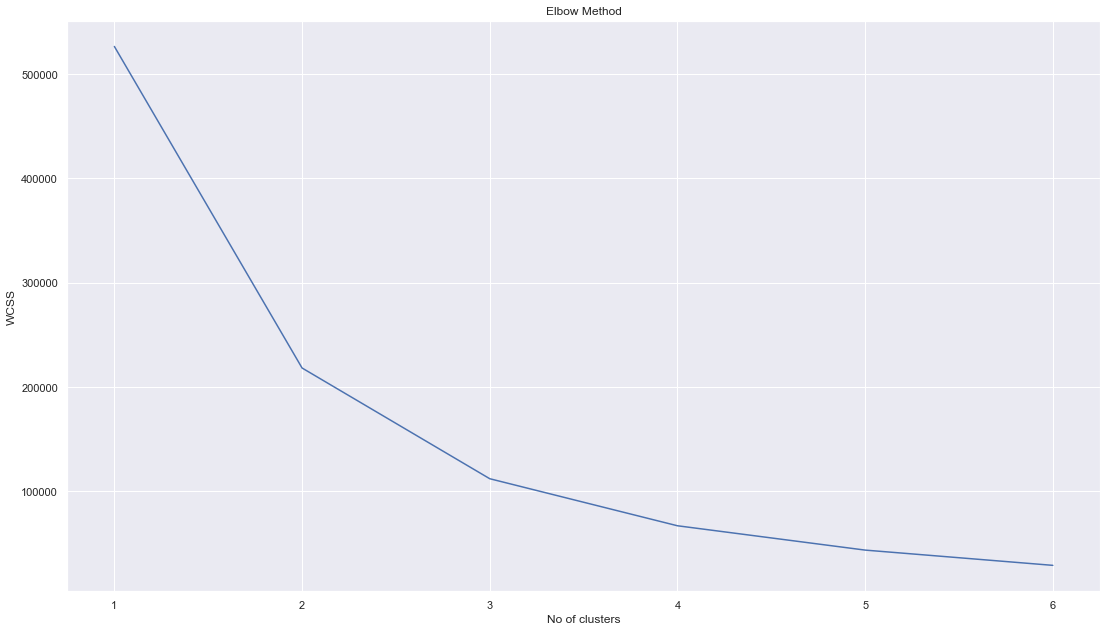

In [19]:
wcss = []
for i in range(1, 7):
    kmeans = KMeans(i)
    kmeans.fit(df)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

number_clusters = range(1,7)

plt.plot(number_clusters,wcss)
plt.title('Elbow Method')
plt.xlabel('No of clusters')
plt.ylabel('WCSS')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

            daily return  ATR_price        VIX  relative_Volume  regime
Date                                                                   
1990-02-28      0.004936   0.013473  21.990000         1.118737       1
1990-03-01      0.002561   0.013191  21.900000         0.963171       1
1990-03-02      0.008415   0.012747  21.340000         1.004143       1
1990-03-05     -0.005365   0.012519  22.030001         0.858562       1
1990-03-06      0.012555   0.012402  20.549999         0.879717       1
...                  ...        ...        ...              ...     ...
2022-07-25      0.001315   0.018995  23.360001         0.796823       1
2022-07-26     -0.011543   0.018866  24.690001         0.826933       1
2022-07-27      0.026156   0.019176  23.240000         0.961075       1
2022-07-28      0.012133   0.019101  22.330000         1.050384       1
2022-07-29      0.014208   0.018659  21.330000         1.035066       1

[8168 rows x 5 columns]
                   Open         High   

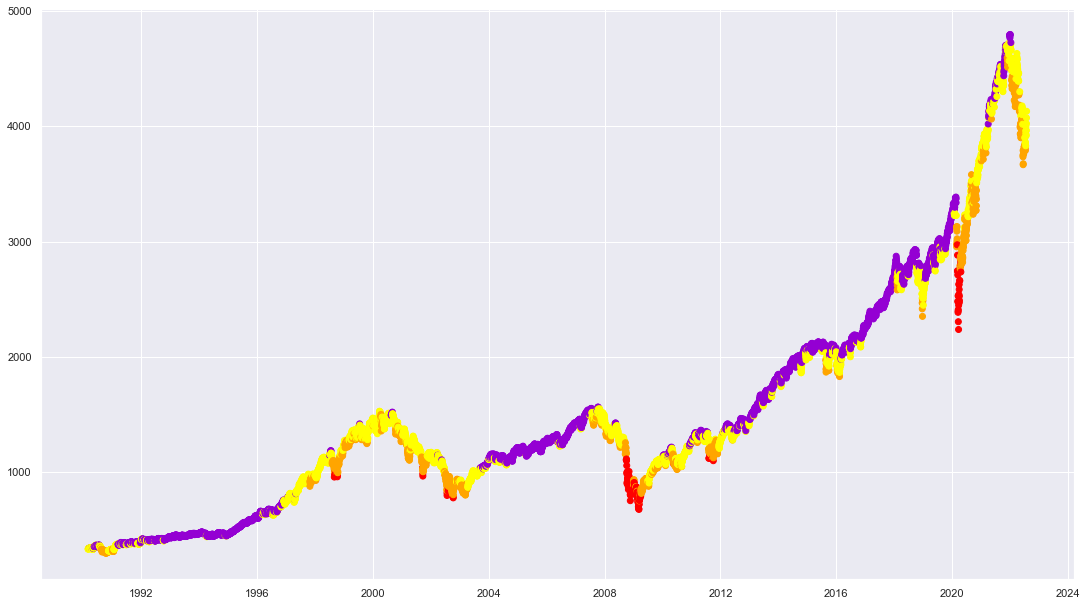

In [21]:
kmeans = KMeans(4)

df['regime'] = kmeans.fit_predict(df)
df_replace['regime'] = df['regime']

print(df)
print(df_replace)

col = []

for i in range(0,len(df_replace)) :
    if df_replace['regime'].iloc[i] == 0:
        col.append('darkviolet')
    elif df_replace['regime'].iloc[i] == 1:
        col.append('yellow')
    elif df_replace['regime'].iloc[i] == 2:
        col.append('orange')
    else:
        col.append('red')
    
print(df.groupby(by=df['regime']).mean())
print(df[df['regime']==2])
                       
                       
plt.scatter(df_replace.index, df_replace['Close'], c=col)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

df.to_csv(r'D:/Downloads/df_regime.csv')
df_replace.to_csv(r'D:/Downloads/df_regime_replace.csv')
